**K-Sparse Experiments**
(reference source: [click here](https://towardsdatascience.com/comparing-different-methods-of-achieving-sparse-coding-in-tensorflow-manual-back-prop-in-tf-d47053da4d8e))

20174375 Sangyoon Lee


### Preliminary Setups

In [1]:
import tensorflow as tf
import numpy as np
import sys, os,cv2
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import imgaug as ia
from sklearn.utils import shuffle
import matplotlib.animation as animation

plt.style.use('seaborn-white')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
np.random.seed(6278)
tf.set_random_seed(6728)
ia.seed(6278)

### Generate Dataset

In [0]:
# Generate training data
import tensorflow as tf
old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
from tensorflow.examples.tutorials.mnist import input_data

### Define Activation Functions & Other Miscellaneous Functions

In [0]:
# Activation Function  
def tf_elu(x): return tf.nn.elu(x)
def d_tf_elu(x): return tf.cast(tf.greater(x,0),tf.float32)  + (tf_elu(tf.cast(tf.less_equal(x,0),tf.float32) * x) + 1.0)
def tf_sigmoid(x): return tf.nn.sigmoid(x)
def d_tf_sigmoid(x): return tf_sigmoid(x) * (1.0-tf_sigmoid(x))

# miscellaneous (Source: https://github.com/tensorflow/tensorflow/issues/8246)
def tf_repeat(tensor, repeats):
    expanded_tensor = tf.expand_dims(tensor, -1)
    multiples = [1] + repeats
    tiled_tensor = tf.tile(expanded_tensor, multiples = multiples)
    repeated_tesnor = tf.reshape(tiled_tensor, tf.shape(tensor) * repeats)
    return repeated_tesnor
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Func: Display Weights (Soruce: https://github.com/jonsondag/ufldl_templates/blob/master/display_network.py)
def display_network(A,current_iter=None):
    opt_normalize = True
    opt_graycolor = True
    # Rescale
    A = A - np.average(A)
    # Compute rows & cols
    (row, col) = A.shape
    sz = int(np.ceil(np.sqrt(row)))
    buf = 1
    n = int(np.ceil(np.sqrt(col)))
    m = int(np.ceil(col / n))
    image = np.ones(shape=(buf + m * (sz + buf), buf + n * (sz + buf)))
    k = 0
    for i in range(int(m)):
        for j in range(int(n)):
            if k >= col:
                continue
            clim = np.max(np.abs(A[:, k]))
            if opt_normalize:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / clim
            else:
                image[buf + i * (sz + buf):buf + i * (sz + buf) + sz, buf + j * (sz + buf):buf + j * (sz + buf) + sz] = \
                    A[:, k].reshape(sz, sz) / np.max(np.abs(A))
            k += 1
    plt.axis('off')
    plt.tight_layout()
    return [plt.imshow(image,cmap='gray', animated=True),plt.text(0.5, 1.0, 'Current Iter : '+str(current_iter),color='red', fontsize=30,horizontalalignment='center', verticalalignment='top')]


### Define Layers

In [17]:
# hyper
num_epoch = 1000
learning_rate = 0.001
batch_size = 100 
print_size = 1

lamda = 0.003
beta1,beta2,adam_e = 0.9,0.999,1e-8
compress_size = 100 # instead of 1000
aimed_sparsity = 0.1; beta = 3.0

# k sparse auto encoders
class k_sparse_layer():

    def __init__(self,inc,outc,special_init=False):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w  = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float64,seed=4))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))

    def getw(self): return self.w

    def feedforward(self,input,k_value = 1):
        self.input = input
        self.layer = tf.matmul(input,self.w)
        self.topk_value = tf.nn.top_k(self.layer, k_value)
        self.topk_masks = tf.cast(tf.greater_equal(self.layer , tf.reduce_min(self.topk_value.values)),tf.float64)
        self.layerA = self.layer * self.topk_masks
        self.reconstructed_layer = tf.matmul(self.layerA,tf.transpose(self.w))
        return self.reconstructed_layer

    def backprop(self,gradient,l2_regularization=False):
        grad_part_1 = gradient
        grad_part_3 = self.layerA

        grad_middle = grad_part_1
        grad = tf.matmul(tf.transpose(grad_middle),grad_part_3)/batch_size

        if l2_regularization:
            grad = grad + lamda * self.w

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (grad)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (grad ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = learning_rate/(tf.sqrt(v_hat) + adam_e) * m_hat
        update_w.append(tf.assign(self.w,tf.subtract(self.w,adam_middle )))

        return grad,update_w

# Simple Sparse
class simple_sparse_layer():

    def __init__(self,inc,outc,special_init=False):
        if special_init:
            interval = np.sqrt(6.0 / (inc + outc + 1.0))
            self.w  = tf.Variable(tf.random_uniform(shape=(inc, outc),minval=-interval,maxval=interval,dtype=tf.float64,seed=4))
        else:
            self.w = tf.Variable(tf.random_normal([inc,outc], stddev=0.05,seed=2,dtype=tf.float64))
        self.m,self.v = tf.Variable(tf.zeros_like(self.w)),tf.Variable(tf.zeros_like(self.w))

    def getw(self): return self.w

    def feedforward(self,input,top_size=1):
        self.input = input
        self.layer = tf.matmul(input,self.w)
        self.top = tf.nn.top_k(self.layer, top_size)
        self.top_mean = tf.reduce_mean(self.top.values)
        self.top_mean_mask = tf.cast(tf.greater_equal(self.layer, self.top_mean),tf.float64)
        self.x_hat = self.top_mean_mask * self.layer
        self.reconstructed_layer = tf.matmul(self.x_hat,tf.transpose(self.w))
        return self.reconstructed_layer

    def backprop(self,l2_regularization=False):
        w_update_1 = tf.expand_dims(tf.reduce_sum(self.input - self.reconstructed_layer,axis=0),0)
        w_update_2 = tf.expand_dims(tf.reduce_sum(tf.sign(self.x_hat),axis=0),0)
        w_update = tf.matmul(tf.transpose(w_update_1),w_update_2)

        if l2_regularization:
            w_update = w_update + lamda * self.w

        update_w = []
        update_w.append(tf.assign( self.m,self.m*beta1 + (1-beta1) * (w_update)   ))
        update_w.append(tf.assign( self.v,self.v*beta2 + (1-beta2) * (w_update ** 2)   ))
        m_hat = self.m / (1-beta1)
        v_hat = self.v / (1-beta2)
        adam_middle = learning_rate/(tf.sqrt(v_hat) + adam_e) * m_hat
        update_w.append(tf.assign(self.w,tf.add(self.w,adam_middle )))
        return w_update, update_w

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz


### Choose whether to use Simple Sparse Layer or K-Sparse Layer

In [0]:
#Change Below Variable
layer = "simple" #or "k"
k = 10 #25, 40, 70

### Training and output results

In [0]:



def training(layer, k):
  # data
  mnist = input_data.read_data_sets('../../Dataset/MNIST/', one_hot=True)
  training_data_og = mnist.train.images
  number_of_trainin_images = 10000
  training_data = training_data_og[0:number_of_trainin_images,:]

  if layer == "simple":
    # layers
    l0 = simple_sparse_layer(784,compress_size,special_init=True)
    # get weigths for reg
    W1 = l0.getw()
    # graph
    x = tf.placeholder(shape=[None,784],dtype=tf.float64)
    layer0 = l0.feedforward(x,top_size=batch_size//2)
    reconstruction_cost = tf.reduce_mean(tf.reduce_sum(tf.square(layer0-x), axis = 1) * 0.5)
    regularization_cost =  lamda * 0.5 * (tf.reduce_sum(W1 ** 2))
    total_cost = reconstruction_cost + regularization_cost
    grad0,grad0_up = l0.backprop(l2_regularization=True)
    grad_update = grad0_up

  else:
    # layers
    l0 = k_sparse_layer(784,compress_size,special_init=True)
    # get weigths for reg
    W1 = l0.getw()
    # graph
    x = tf.placeholder(shape=[None,784],dtype=tf.float64)
    layer0 = l0.feedforward(x,k_value=k)
    reconstruction_cost = tf.reduce_mean(tf.reduce_sum(tf.square(layer0-x), axis = 1) * 0.5)
    regularization_cost =  lamda * 0.5 * (tf.reduce_sum(W1 ** 2))
    total_cost = reconstruction_cost + regularization_cost
    grad0,grad0_up = l0.backprop(layer0-x,l2_regularization=True)
    grad_update = grad0_up






  with tf.Session() as sess:

      sess.run(tf.global_variables_initializer())
      train_cota =0;train_cot = [];image_list = []
      fig = plt.figure(figsize=(8, 8))

      # train for current iter
      for iter in range(num_epoch):

          training_data = shuffle(training_data)

          for current_batch_index in range(0,len(training_data),batch_size):
              current_training_data = training_data[current_batch_index:current_batch_index+batch_size]
              sess_results = sess.run([total_cost,grad_update],feed_dict={x:current_training_data})
              print("Current Iter : ",iter,' Current cost: ', sess_results[0],end='\r')
              train_cota = train_cota + sess_results[0]

          if iter % print_size==0:
              print("\n----------")
              print('Train Cost overtime : ', train_cota/(len(training_data)/batch_size),end='\n')
              print("----------")
              image_list.append(display_network(sess.run(W1),current_iter=iter))

          train_cot.append(train_cota/(len(training_data)/batch_size)); train_cota = 0

      # save the weights and how they changed over time
      ani = animation.ArtistAnimation(fig, image_list, interval=50, blit=True,repeat_delay=1000)
      name = ""
      if layer =="simple":
        name = "simple_sparse.mp4"
      else:
        name = "k_sparse"+str(k)
        name = name+".mp4"
      
      ani.save(name)
      plt.show()
      plt.close('all')

      # training done
      plt.figure()
      plt.plot(range(len(train_cot)),train_cot,color='green',label='cost OVT')
      plt.legend()
      plt.title("Train Average Cost Over Time")
      plt.show()
      plt.close('all')

      # Display the final Trained Resutls
      training_data_show = training_data[:compress_size]
      training_data_reshape = np.reshape(training_data_show,(compress_size,28,28))
      fig=plt.figure(figsize=(8, 8))
      columns = int(np.sqrt(compress_size)); rows = int(np.sqrt(compress_size))
      for i in range(1, columns*rows +1):
          fig.add_subplot(rows, columns, i)
          plt.axis('off')
          plt.imshow(training_data_reshape[i-1,:,:],cmap='gray')
      plt.show()
      plt.close('all')

      # Show the reconstruction data
      train_batch = training_data[:batch_size]
      recon_data = sess.run(layer0,feed_dict={x:train_batch})[:compress_size]
      recon_data_reshape = np.reshape(recon_data,(compress_size,28,28))
      fig=plt.figure(figsize=(8, 8))
      for i in range(1, columns*rows +1):
          fig.add_subplot(rows, columns, i)
          plt.axis('off')
          plt.imshow(recon_data_reshape[i-1,:,:],cmap='gray')
      plt.show()
      plt.close('all')

      # show trainied weigths constrast norm
      plt.figure(figsize=(8, 8))
      plt.axis('off')
      display_network(sess.run(W1))
      plt.show()
      plt.close('all')

      # Show the trained weights
      trained_w1 = sess.run(W1)
      trained_w1_data_reshape = np.reshape(trained_w1.T,(compress_size,28,28))
      fig=plt.figure(figsize=(8, 8))
      for i in range(1, columns*rows +1):
          fig.add_subplot(rows, columns, i)
          plt.axis('off')
          plt.imshow(trained_w1_data_reshape[i-1,:,:],cmap='gray')
      plt.show()
      plt.close('all')





K-Sparse Autoencoder K = 10

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz
Current Iter :  0  Current cost:  11.401740955571588
----------
Train Cost overtime :  18.51215430003965
----------
Current Iter :  1  Current cost:  9.598827763258587
----------
Train Cost overtime :  9.980540746324998
----------
Current Iter :  2  Current cost:  8.538030734992747
----------
Train Cost overtime :  8.553993418450238
----------
Current Iter :  3  Current cost:  7.088060193688051
----------
Train Cost overtime :  7.848538998079313
----------
Current Iter :  4  Current cost:  6.869628038668511
----------
Train Cost overtime :  7.446853322362063
----------
Current Iter :  5  Current cost:  6.690212017786354
----------
Train Cost overtime :  7.1100644269390285
----------
Current Iter :  6  Current cost:  7.017479722516093
----------
Train Cost over

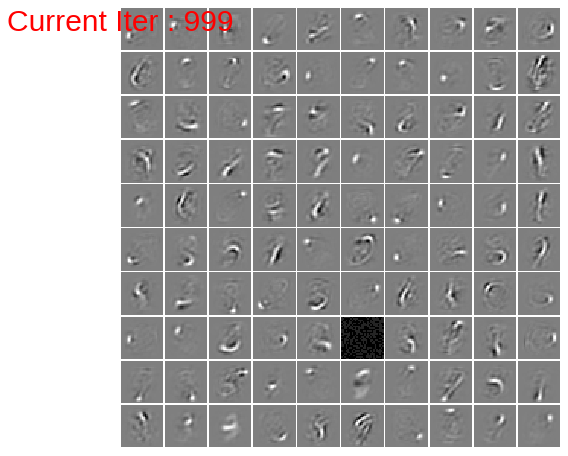

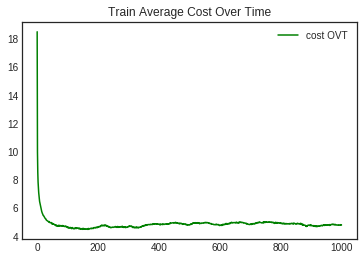

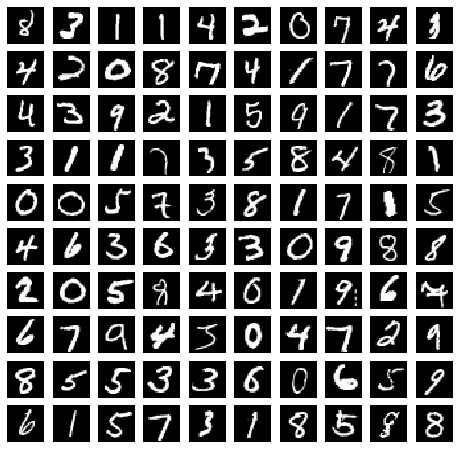

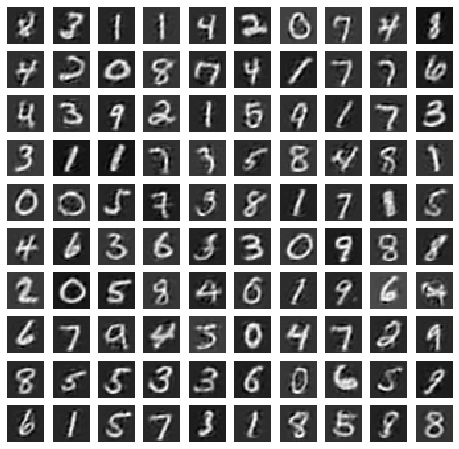

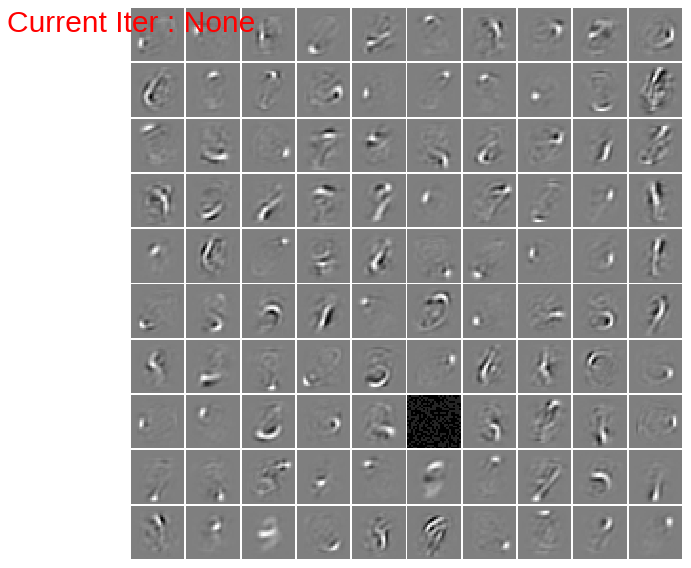

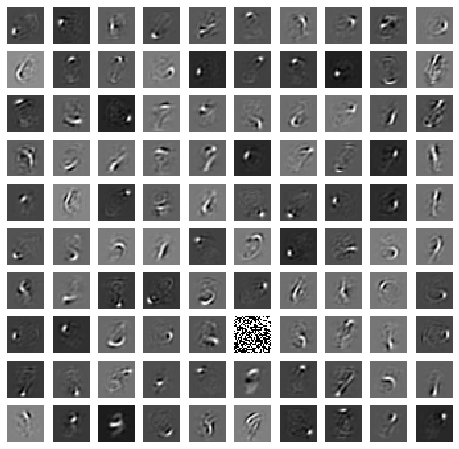

In [24]:
layer = "k" #or "k"
k = 10 
training(layer,k)

K-Sparse Autoencoder K = 25

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz
Current Iter :  0  Current cost:  10.32199113300472
----------
Train Cost overtime :  16.964593450198695
----------
Current Iter :  1  Current cost:  8.570834975719682
----------
Train Cost overtime :  8.849013165070547
----------
Current Iter :  2  Current cost:  6.937053856925255
----------
Train Cost overtime :  7.390441235969921
----------
Current Iter :  3  Current cost:  5.900798415341027
----------
Train Cost overtime :  6.60771912906761
----------
Current Iter :  4  Current cost:  5.560809084311555
----------
Train Cost overtime :  6.164585046791243
----------
Current Iter :  5  Current cost:  5.527029494640014
----------
Train Cost overtime :  5.877060234667268
----------
Current Iter :  6  Current cost:  5.548967553157639
----------
Train Cost overti

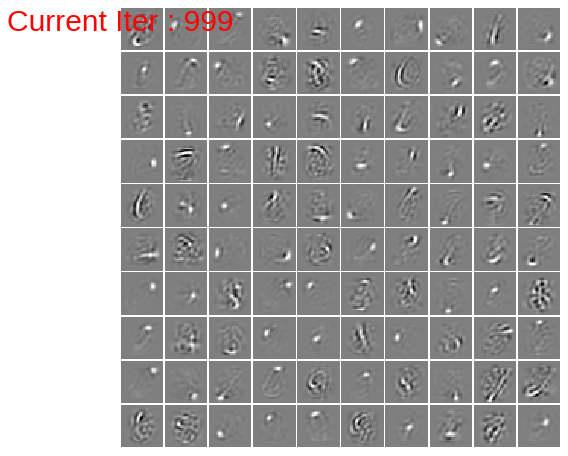

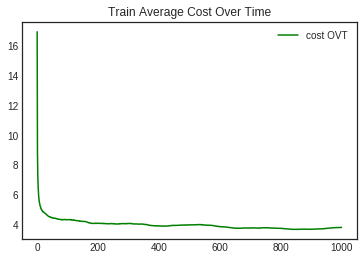

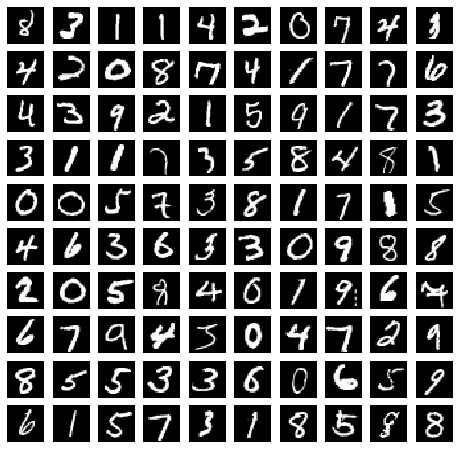

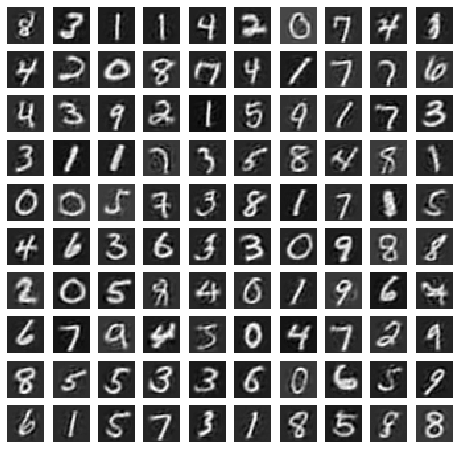

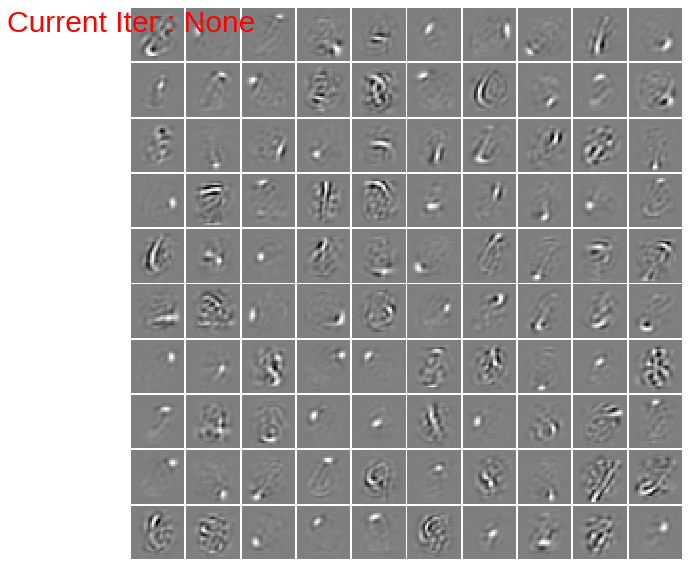

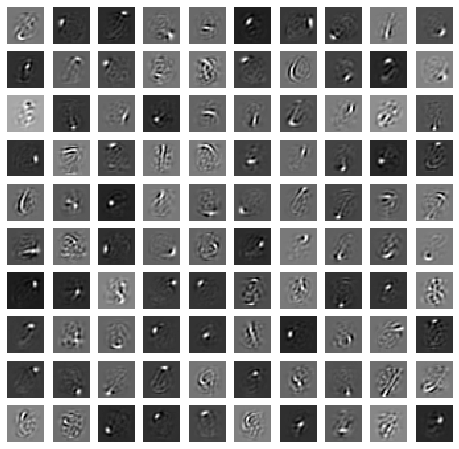

In [25]:
layer = "k" #or "k"
k = 25
training(layer,k)

K-Sparse Autoencoder K = 40

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz
Current Iter :  0  Current cost:  9.633970136223214
----------
Train Cost overtime :  16.449490297408783
----------
Current Iter :  1  Current cost:  7.997223749378659
----------
Train Cost overtime :  8.580321244548946
----------
Current Iter :  2  Current cost:  6.482353361819283
----------
Train Cost overtime :  7.13358853918407
----------
Current Iter :  3  Current cost:  5.833227690509653
----------
Train Cost overtime :  6.4099136394350955
----------
Current Iter :  4  Current cost:  5.4917001284035285
----------
Train Cost overtime :  5.984777952917097
----------
Current Iter :  5  Current cost:  5.461069031042398
----------
Train Cost overtime :  5.703355472719637
----------
Current Iter :  6  Current cost:  5.5919010717749105
----------
Train Cost ove

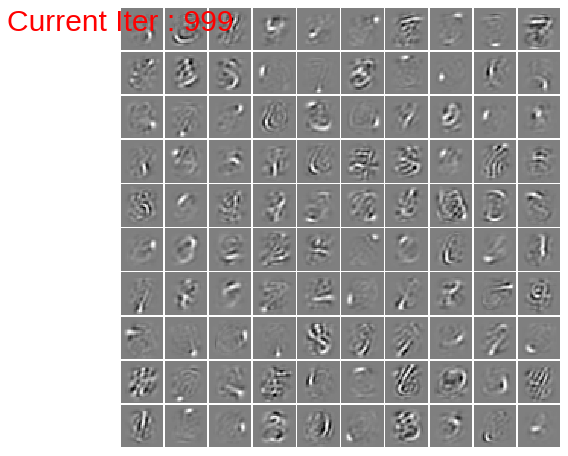

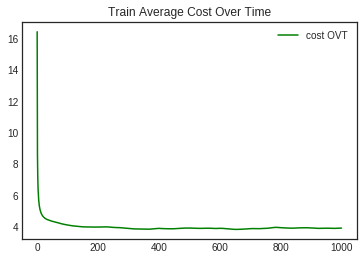

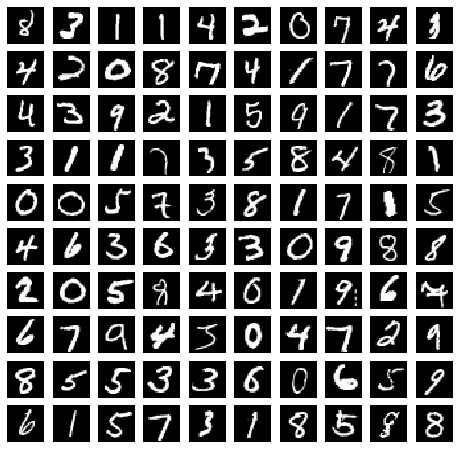

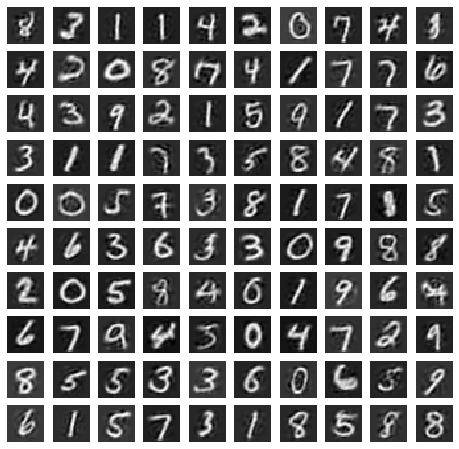

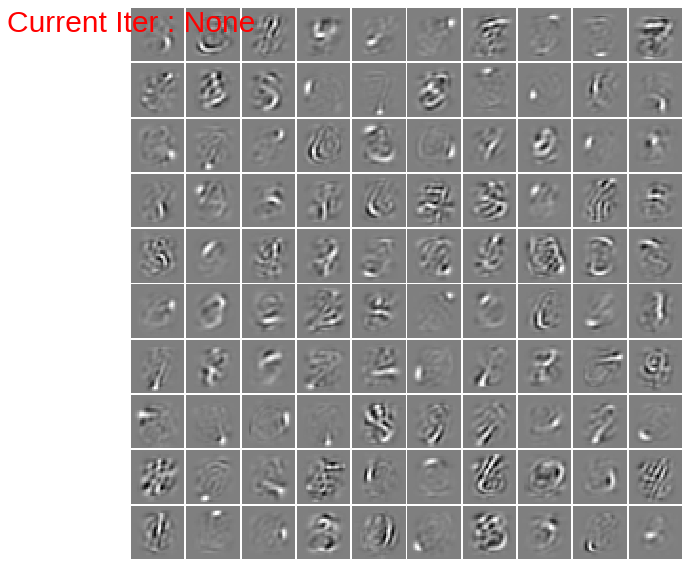

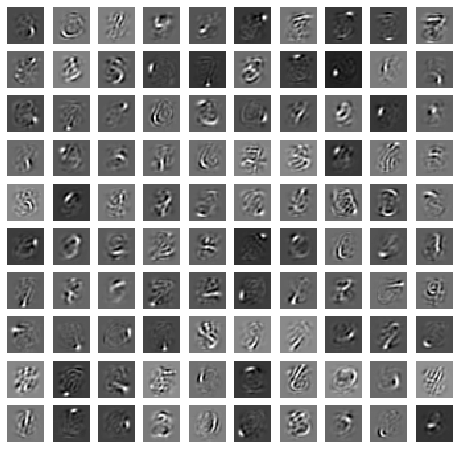

In [26]:
layer = "k" #or "k"
k = 40
training(layer,k)

K-Sparse Autoencoder K = 70

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz
Current Iter :  0  Current cost:  9.663831469057726
----------
Train Cost overtime :  17.040652452024855
----------
Current Iter :  1  Current cost:  7.891671518271441
----------
Train Cost overtime :  8.597795619833743
----------
Current Iter :  2  Current cost:  6.460966322334163
----------
Train Cost overtime :  7.139266337349207
----------
Current Iter :  3  Current cost:  6.087801808362508
----------
Train Cost overtime :  6.493618538631129
----------
Current Iter :  4  Current cost:  5.772725375181454
----------
Train Cost overtime :  6.13591867466088
----------
Current Iter :  5  Current cost:  5.690000325040948
----------
Train Cost overtime :  5.902420033556872
----------
Current Iter :  6  Current cost:  5.82039660523659
----------
Train Cost overtim

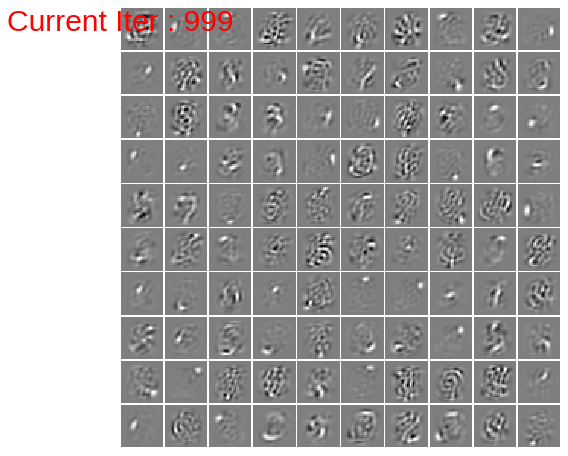

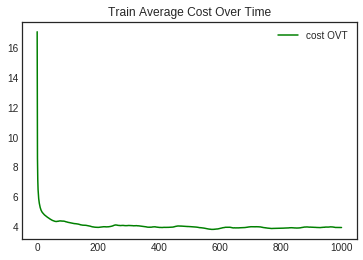

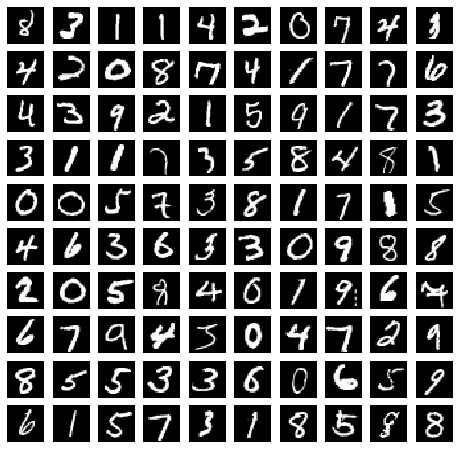

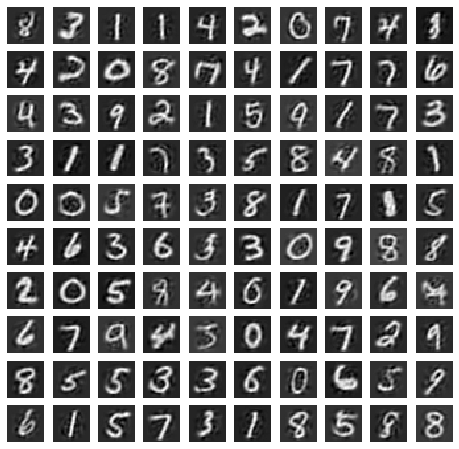

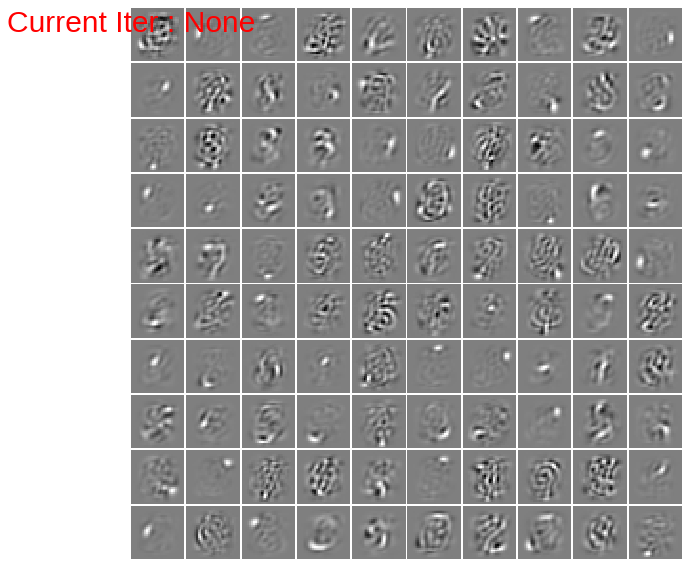

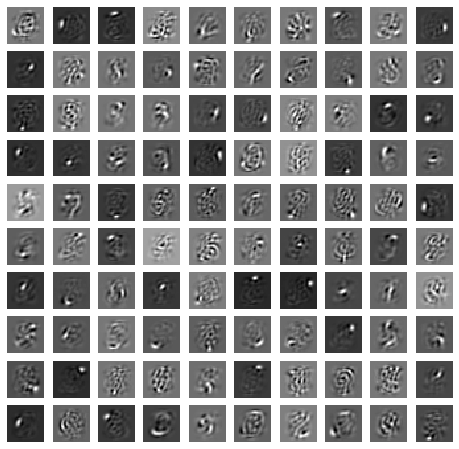

In [27]:
layer = "k" #or "k"
k = 70
training(layer,k)

Simple Sparse Coding

Extracting ../../Dataset/MNIST/train-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/train-labels-idx1-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-images-idx3-ubyte.gz
Extracting ../../Dataset/MNIST/t10k-labels-idx1-ubyte.gz
Current Iter :  0  Current cost:  35.27723336241935
----------
Train Cost overtime :  38.82887705009865
----------
Current Iter :  1  Current cost:  34.7164609133109
----------
Train Cost overtime :  34.89427569707328
----------
Current Iter :  2  Current cost:  33.55850355845957
----------
Train Cost overtime :  34.51724794757379
----------
Current Iter :  3  Current cost:  35.26778276215811
----------
Train Cost overtime :  34.18620459458396
----------
Current Iter :  4  Current cost:  34.26603923083733
----------
Train Cost overtime :  33.561547429697846
----------
Current Iter :  5  Current cost:  33.76872421469308
----------
Train Cost overtime :  32.88318271657331
----------
Current Iter :  6  Current cost:  31.701264358896427
----------
Train Cost overt

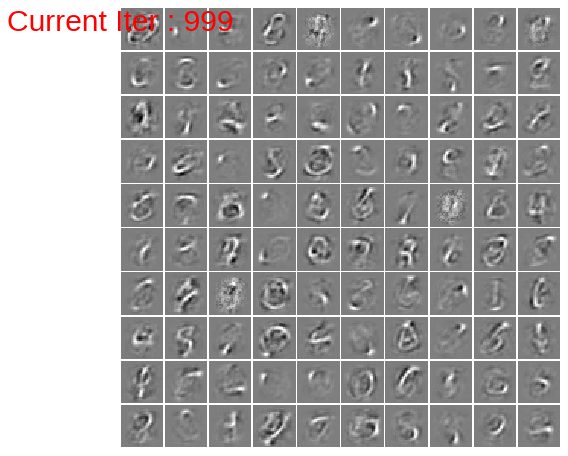

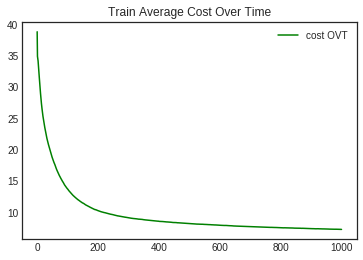

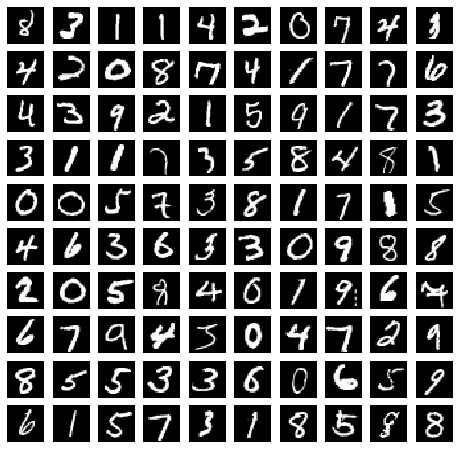

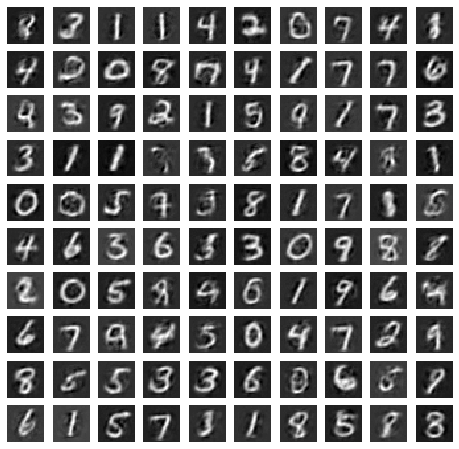

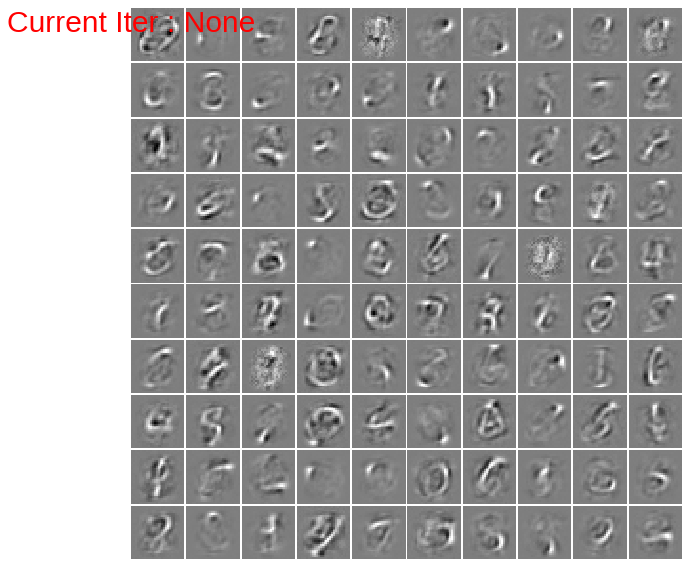

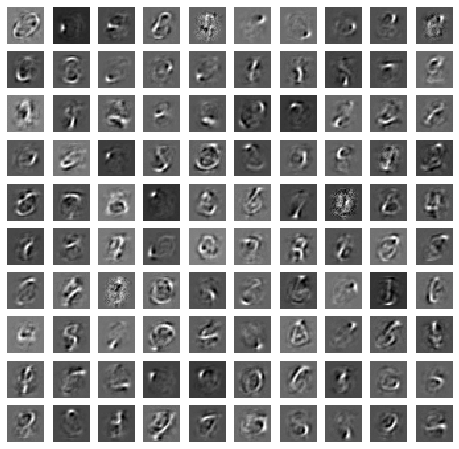

In [28]:
layer = "simple" #or "k"
k = 10 #25, 40, 70
training(layer,k)